# Imports

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

2023-03-07 15:15:10.889393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 15:15:11.596616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 15:15:11.596683: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-07 15:15:11.712369: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-07 15:15:13.649448: W tensorflow/stream_executor/platform/de

# Data loading

In [150]:
X_movies = pd.read_csv("./../raw_data/sample_movies_reviews_clean.csv")

In [151]:
X_books = pd.read_csv("./../raw_data/sample_books_reviews_clean.csv")

### Extracting the lists out of the strings and removing unnecessary columns

In [152]:
X_books["txt_flatten"] = X_books["txt"].apply(lambda x: eval(x))

In [153]:
X_movies.drop(columns=["Unnamed: 0"], inplace=True)

In [154]:
X_movies["txt_flatten"] = X_movies["txt"].apply(lambda x: eval(x))

In [155]:
X_books = X_books.drop(columns=["Unnamed: 0", "txt"])

In [156]:
X_movies = X_movies.drop(columns=["txt"])

### Grouping the reviews by movies_id and book_id
### Adding a "is_movie" column to keep track of the category of each item
### Resetting index in order to keep the item_id for each book and movie

array([[<Axes: title={'center': 'txt_flatten'}>]], dtype=object)

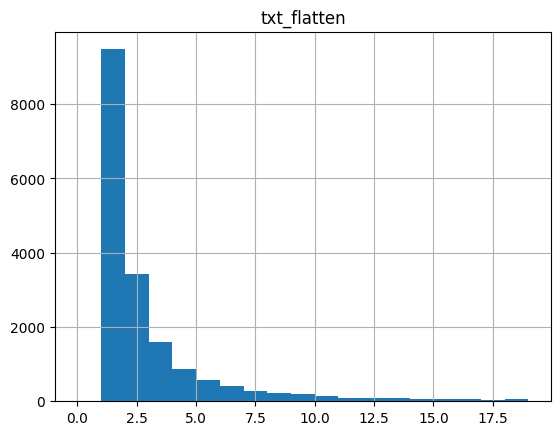

In [167]:
X_movies.groupby("item_id").count().hist(bins=[*range(20)])

array([[<Axes: title={'center': 'txt_flatten'}>]], dtype=object)

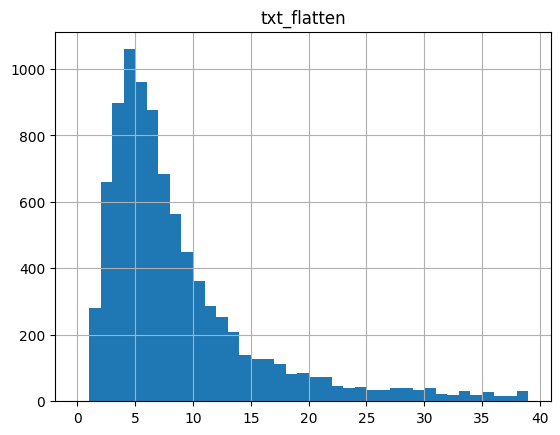

In [165]:
X_books.groupby("item_id").count().hist(bins=[*range(40)])

In [64]:
X_books_agg = X_books.groupby("item_id").sum()

In [65]:
X_movies_agg = X_movies.groupby("item_id").sum()

In [66]:
X_books_agg["is_movie"] = 0

In [67]:
X_books_agg.reset_index(inplace=True)

In [75]:
X_books_agg.rename({"item_id":"item_id_book"}, axis='columns', inplace=True)

In [68]:
X_movies_agg["is_movie"] = 1

In [69]:
X_movies_agg.reset_index(inplace=True)

In [76]:
X_movies_agg.rename({"item_id":"item_id_movie"}, axis='columns',inplace=True)

In [77]:
X_reviews = pd.concat([X_movies_agg, X_books_agg])

In [78]:
X_reviews

,item_id_movie,txt_flatten,is_movie,item_id_book
0,1.0,"[dont, call, play, nothing, open, scene, say, ...",1,NaN
1,2.0,"[creative, story, eventshumour, get, old, quic...",1,NaN
2,3.0,"[pretty, dang, funny, john, max, resolve, save...",1,NaN
3,4.0,"[bad, movie, story, quite, good, wholems, bass...",1,NaN
4,5.0,"[father, bride, part, ii, first, film, remake,...",1,NaN
...,...,...,...,...
9308,NaN,"[yes, dark, taboo, read, love, take, dark, pla...",0,56707521.0
9309,NaN,"[fish, hook, star, sweet, read, good, thing, h...",0,56872973.0
9310,NaN,"[idea, read, im, confuse, im, pretty, sure, li...",0,56992688.0
9311,NaN,"[really, enjoy, book, landon, delicious, rana,...",0,57041703.0


### Looking at the distribution of reviews lengths

In [170]:
X_movies_agg["length_txt"] = X_movies_agg["txt_flatten"].apply(lambda x: len(x))

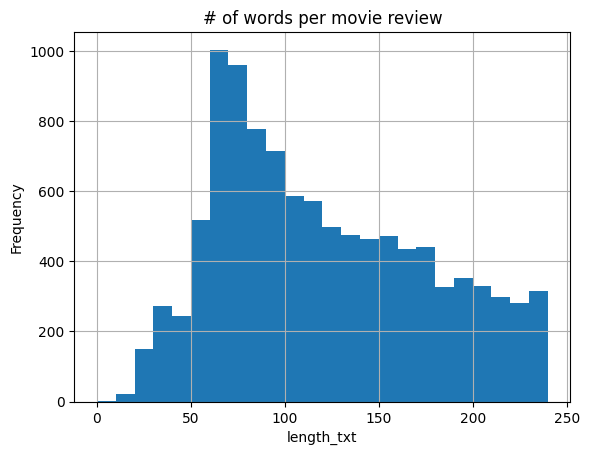

In [175]:
X_movies_agg["length_txt"].hist(bins=[*range(0,250,10)])
plt.xlabel("length_txt")
plt.ylabel("Frequency")
plt.title("# of words per movie review");

In [176]:
X_books_agg["length_txt"] = X_books_agg["txt_flatten"].apply(lambda x: len(x))

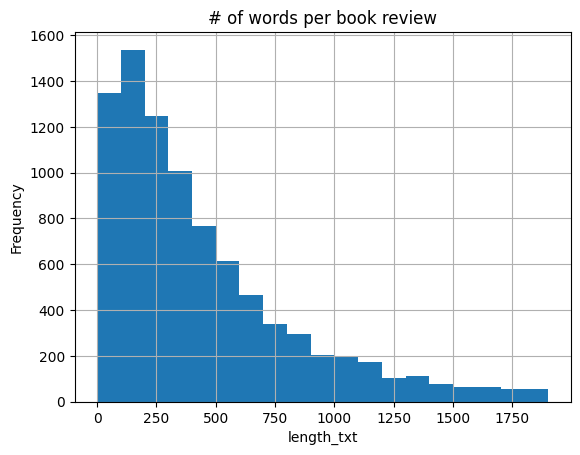

In [178]:
X_books_agg["length_txt"].hist(bins=[*range(0,2000,100)])
plt.xlabel("length_txt")
plt.ylabel("Frequency")
plt.title("# of words per book review");

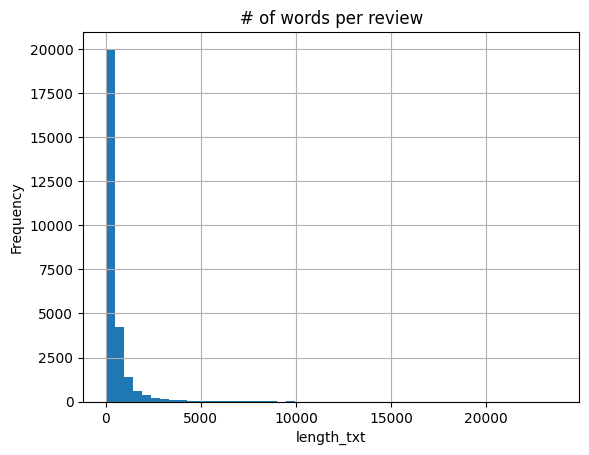

In [97]:
X_reviews["length_txt"].hist(bins=50)
plt.xlabel("length_txt")
plt.ylabel("Frequency")
plt.title("# of words per review (book + movie)");

# Word2Vec

In [18]:
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
#TODO use another word2vec

In [19]:
word2vec_transfer = api.load("glove-wiki-gigaword-50")

In [20]:
word2vec_transfer.vector_size

50

In [21]:
print(len(word2vec_transfer.key_to_index))

400000


In [20]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [21]:
# Embed the training and test sentences
# X_embed = embedding(word2vec_transfer, X_reviews["txt_flatten"])

In [24]:
# Pad the training and test embedded sentences
# TODO: maxlen could be increased
# X_pad = pad_sequences(X_embed, dtype='float32', padding='post', maxlen=1000, value=0)

: 

: 

In [22]:
np.shape(X_embed)

/home/arostagnat/.pyenv/versions/3.10.6/envs/BookMatch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(27372,)

In [28]:
np.shape(X_embed[3])

(218, 50)

In [23]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features


In [79]:
vectorized_docs = vectorize(X_reviews["txt_flatten"], model=word2vec_transfer)

In [80]:
len(vectorized_docs), len(vectorized_docs[0])

(27372, 50)

In [81]:
vectorized_docs

[array([ 0.14430365,  0.1230157 , -0.07770059, -0.08035196,  0.37081507,
         0.10470017, -0.34897268, -0.20101967, -0.13121238,  0.33800128,
        -0.12216133,  0.26838082, -0.24184509,  0.17785667,  0.5105012 ,
         0.08344451,  0.16967462,  0.19849513, -0.232304  , -0.36245513,
         0.04888343,  0.26336163,  0.0620812 ,  0.15819359,  0.39066267,
        -1.0747398 , -0.6897786 ,  0.03421633,  0.35178116, -0.33497173,
         2.2263966 ,  0.16532448, -0.03589325, -0.28804836, -0.0377427 ,
         0.1369418 , -0.02600464,  0.03394901, -0.1727474 , -0.4292038 ,
        -0.09219838,  0.16544102, -0.20240088,  0.03534847,  0.02702761,
         0.09054346,  0.12130627, -0.20319393, -0.14389747,  0.31435984],
       dtype=float32),
 array([ 0.1509188 ,  0.12513167, -0.13337524, -0.16415817,  0.34971347,
         0.09974509, -0.39618686, -0.09271086, -0.13311937,  0.27974996,
        -0.13616572,  0.2683875 , -0.32698196,  0.15062377,  0.5990503 ,
         0.10681017,  0.246

In [ ]:
#TOD0: Use different clustering methods

In [33]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [82]:
# km = MiniBatchKMeans(n_clusters=75, batch_size=500).fit(vectorized_docs)

/home/arostagnat/.pyenv/versions/3.10.6/envs/BookMatch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [83]:
kmeans = KMeans(n_clusters=75).fit(vectorized_docs)

/home/arostagnat/.pyenv/versions/3.10.6/envs/BookMatch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
np.unique(km.labels_, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [84]:
X_reviews["batch_label"] = km.labels_

In [85]:
X_reviews["Kmeans_label"] = kmeans.labels_

In [86]:
metadata_movies = pd.read_json("./../raw_data/raw_movies/metadata.json", lines=True)

In [87]:
metadata_books = pd.read_json("./../raw_data/raw_book/metadata.json", lines=True)

In [107]:
X_reviews

,item_id_movie,txt_flatten,is_movie,item_id_book,batch_label,Kmeans_label
0,1.0,"[dont, call, play, nothing, open, scene, say, ...",1,NaN,38,54
1,2.0,"[creative, story, eventshumour, get, old, quic...",1,NaN,31,30
2,3.0,"[pretty, dang, funny, john, max, resolve, save...",1,NaN,70,69
3,4.0,"[bad, movie, story, quite, good, wholems, bass...",1,NaN,20,13
4,5.0,"[father, bride, part, ii, first, film, remake,...",1,NaN,49,13
...,...,...,...,...,...,...
9308,NaN,"[yes, dark, taboo, read, love, take, dark, pla...",0,56707521.0,57,73
9309,NaN,"[fish, hook, star, sweet, read, good, thing, h...",0,56872973.0,33,15
9310,NaN,"[idea, read, im, confuse, im, pretty, sure, li...",0,56992688.0,33,49
9311,NaN,"[really, enjoy, book, landon, delicious, rana,...",0,57041703.0,53,15


In [108]:
X_reviews[X_reviews["is_movie"] == 1].shape

(18059, 6)

In [91]:
metadata_movies.rename({"item_id":"item_id_movie"}, axis='columns',inplace=True)

In [101]:
metadata_movies.shape

(84661, 7)

In [110]:
merged_movies = pd.merge(X_reviews, metadata_movies, on="item_id_movie", how="left")

In [112]:
metadata_books.rename({"item_id":"item_id_book"}, axis='columns',inplace=True)

In [113]:
merged_all = pd.merge(merged_movies, metadata_books, on="item_id_book", how="left")

In [123]:
final_df = merged_all[["title_x","title_y","batch_label", "Kmeans_label", "is_movie" ]]

In [124]:
final_df["Kmeans_label"].value_counts()

62    883
73    878
5     797
57    748
4     739
     ... 
9      28
22     27
60     23
48     19
31      1
Name: Kmeans_label, Length: 75, dtype: int64

In [133]:
final_df = final_df.fillna("")

In [148]:
final_df[final_df["title_x"].str.contains("rocky", case=False)]

,title_x,title_y,batch_label,Kmeans_label,is_movie
1231,Rocky (1976),,6,62,1
1585,Rocky II (1979),,17,23,1
1586,Rocky III (1982),,14,62,1
1587,Rocky IV (1985),,19,5,1
1588,Rocky V (1990),,28,51,1
1777,"Rocky Horror Picture Show, The (1975)",,31,11,1
2554,"Adventures of Rocky and Bullwinkle, The (2000)",,70,30,1
7452,Rocky Balboa (2006),,14,69,1
16810,The Rocky Horror Picture Show: Let's Do the Ti...,,6,56,1


In [149]:
final_df[final_df["Kmeans_label"]==69]

,title_x,title_y,batch_label,Kmeans_label,is_movie
2,Grumpier Old Men (1995),,70,69,1
9,"American President, The (1995)",,14,69,1
54,Friday (1995),,31,69,1
65,White Squall (1996),,14,69,1
127,Nine Months (1995),,9,69,1
...,...,...,...,...,...
21724,,"Happy Ever After (Bride Quartet, #4)",16,69,0
22883,,"Celebrity in Death (In Death, #34)",31,69,0
24078,,Nothing Can Possibly Go Wrong,31,69,0
25644,,"The Burning Room (Harry Bosch, #19; Harry Bosc...",24,69,0


In [ ]:
merged[merged["label"]==1]

In [ ]:
mask = X_train["label"]==1
X_train[mask]

In [ ]:
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_